<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynNN_figures_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings - Paths - Clone github rep

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# clone github
!git clone https://github.com/katduecker/dnn_osci

# enter folder
%cd dnn_osci
%cd aet_pytorch/


load_NN = True      # load pre-trained NN?
save_NN = False       # save trained NN?

Mounted at /content/drive
Cloning into 'dnn_osci'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 651 (delta 119), reused 150 (delta 77), pack-reused 413
Receiving objects: 100% (651/651), 206.66 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (337/337), done.
/content/dnn_osci
/content/dnn_osci/aet_pytorch


In [2]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations

import scipy


In [3]:
import aet_net            # 1-layer architecture
import aet_net_2lay       # 2-layer architecture



## Helper functions

In [4]:
# sigmoid activation with option to stretch and shift
def sigmoid(z,sig_param):

    _slope,_bias = sig_param

    return 1.0/(1.0+np.exp(-_slope*(z+_bias)))

In [5]:
# forward dynamics/discretization, euler integration
def euler_dyn(Z,t_,params_,alpha_params_,sig_param,t_start=0):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S = params_


    # alpha frequency & amplitude
    _af,_aa,_ap = alpha_params_


    # initialize empty matrices
    dt = np.diff(t_)[0]
    dh1dt = (np.zeros((len(t_)+1,)))
    dR1dt = (np.zeros((len(t_)+1,)))
    dZdt = (np.zeros((len(t_)+1,)))

    dR1dt[0] = (c/(c-1))*Z
    dh1dt[0] = Z/(c-1)

    # alpha inhibition
    alpha_inh1 = _aa*np.sin(2*np.pi*_af*t_+_ap)+_aa

    boxcar = np.zeros(len(t_))
    boxcar[t_start:] = 1

    for _it,t in enumerate(t_):

        # pre-activation
        dZdt[_it+1] = (Z*boxcar[_it] + dh1dt[_it] - dR1dt[_it] - alpha_inh1[_it])/S

        # dynamics hidden layer1
        dh1dt[_it+1] = dh1dt[_it] + dt/tau_h * (-dh1dt[_it] + sigmoid(dZdt[_it+1],sig_param))

        # adaptation term 1
        dR1dt[_it+1] = dR1dt[_it] + dt/tau_R * (-dR1dt[_it] + c*dh1dt[_it+1])



    return dZdt, dh1dt, dR1dt

Find fixed point numerically

$0 = -R + c\cdot H$

$ \frac{dH}{dt} = - H + \sigma(-a\frac{Z-R+H}{S}-b)$

$0 = -H + \frac{1}{1+e^{-a(\frac{Z-R+H}{S}-b)}}$

$\frac{1}{H} = 1 + e^{-a(\frac{Z-R+H}{S}-b)}$


$\frac{1}{H} - 1 = e^{-(a\frac{Z-R+H}{S}-b)}$

$ln(\frac{1}{H} - 1) = -a(\frac{Z-R+H}{S}-b)$

$\frac{ln(\frac{1}{H} - 1)}{a} = -\frac{Z-R+H}{S}+b$

$\frac{ln(\frac{1}{H} - 1)}{a} - b = -\frac{Z-R+H}{S}$

$S \cdot (\frac{ln(\frac{1}{H} - 1)}{a} - b) = -Z + c\cdot H - H$

$Z + S \cdot (\frac{ln(\frac{1}{H} - 1)}{a} - b) = H\cdot(c-1)$

$\frac{Z}{c-1} + \frac{S}{c-1} (\frac{ln(\frac{1}{H} - 1)}{a} - b) = H $



In [ ]:
# fixed points

def func(x,Z,c,S):

  return (Z/(c-1))+(S/(c-1))*(np.log(1/x-1)/2-2.5)-x

In [118]:
x = np.zeros_like(Z)

for i,z in enumerate(Z):

  x[i] = fsolve(func,0.01,args=(z.detach().numpy(),c.detach().numpy(),S))[0]


x

<ipython-input-97-f6cd4392246b>:7: RuntimeWarning: invalid value encountered in log
  return (Z/(c-1))+(S/(c-1))*(np.log(1/x-1)/2-2.5)-x


array([0.11241268, 0.54765403, 0.0237898 , 0.01      , 0.45373973,
       0.07590237, 0.42678392, 0.39242756, 0.46825737, 0.01      ,
       0.44852853, 0.04294113, 0.16764638, 0.4180014 , 0.01      ,
       0.09411385, 0.4641466 , 0.01736249, 0.00253892, 0.05878776,
       0.41511258, 0.01      , 0.01      , 0.01      , 0.49767408,
       0.4326449 , 0.25844917, 0.01      , 0.01      , 0.01      ,
       0.00617102, 0.3838453 ], dtype=float32)

In [128]:
# 2-layer NN Euler

# scaled c to each Z

def euler_dyn_2layer(model,input_,params_,t_,alpha_params,DEVICE,inp_on,start_fix = True):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S = params_


    # alpha frequency & amplitude
    _af,_aa,_aph = alpha_params


    with torch.no_grad():

        # preactivation (dot product of input and first weight matrix)
        Z,H,_,_= model.forw_conv(input_)
        Z2 = model.fc1(H)

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dh1dt = (torch.ones((model.dims[1],len(t_)+1))).to(DEVICE)
        dR1dt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)



        dh2dt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)
        dR2dt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)

        if start_fix:

          # start at approximated fixed point (otherwise dynamics are not reached)
          for i,z in enumerate(Z):

            dR1dt[i,0] = (c/(c-1))*z
            dh1dt[i,0] = z/(c-1)

          for i,z in enumerate(Z2):
            dR2dt[i,0] = (c/(c-1))*z
            dh2dt[i,0] = z/(c-1)


        dOdt = (torch.zeros((model.dims[3],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)
        dZ2dt = (torch.ones((model.dims[2],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh1 = _aa[0]*np.sin(2*np.pi*_af[0]*t_+_aph[0])+_aa[0]
        alpha_inh2 = _aa[1]*np.sin(2*np.pi*_af[1]*t_+_aph[0])+_aa[1]




        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,H1,H2,O = model.forw_conv(input_*boxcar[_it])

          # pre-activation
            dZdt[:,_it+1] = (Z + dh1dt[:,_it] - dR1dt[:,_it] - alpha_inh1[_it])/S

            # dynamics hidden layer
            dh1dt[:,_it+1] = dh1dt[:,_it] + dt/tau_h * (-dh1dt[:,_it] + model.acti1(dZdt[:,_it+1],model.sig_param[0]))

            # adaptation term
            dR1dt[:,_it+1] = dR1dt[:,_it] + dt/tau_R * (-dR1dt[:,_it] + c*dh1dt[:,_it+1])


            # pre-activation layer 2
            Z2 =  model.fc1(H1)

            dZ2dt[:,_it+1] = (model.fc1(dh1dt[:,_it+1]) + dh2dt[:,_it+1] - dR2dt[:,_it]- alpha_inh2[_it])/S
            # dynamics hidden layer1
            dh2dt[:,_it+1] = dh2dt[:,_it] + dt/tau_h * (-dh2dt[:,_it] + aet_net_2lay.sigmoid(dZ2dt[:,_it+1],model.sig_param[1]))

            # # adaptation term 2
            dR2dt[:,_it+1] = dR2dt[:,_it] + dt/tau_R * (-dR2dt[:,_it] + c*dh2dt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc2(dh2dt[:,_it+1]))

    return dZdt, dZ2dt, dh1dt, dR1dt, dh2dt, dR2dt,dOdt

In [7]:
# create stimuli

x_train, y_train = aet_net_2lay.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# Concept figure

In [8]:
!pip install cmcrameri;

from cmcrameri import cm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 3.2 MB/s eta 0:00:00


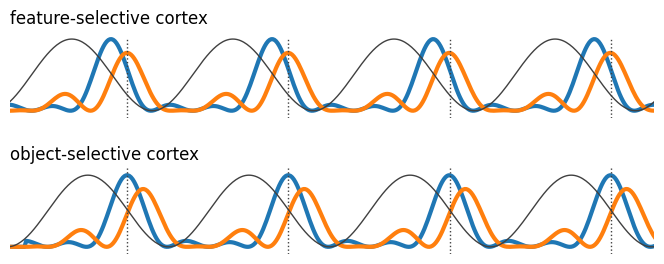

In [9]:
## Concept figure life

timevec = np.linspace(0,1,1000)
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (7,3)


fig, axs = plt.subplots(2,1)

stim1 = 0.5*np.sin(2*np.pi*timevec*20)+0.5
stim2 = 0.45*np.sin(2*np.pi*timevec*20-np.pi/2)+0.45
alpha = 0.5*np.sin(2*np.pi*timevec*10+np.pi+np.pi/3-np.pi/100*10)+0.5
alpha_plot =0.5*np.cos(2*np.pi*timevec*10+np.pi+np.pi/3-np.pi/100*10)+0.5

s1 = stim1*alpha;
s11 = s1#np.concatenate((s1[:190],np.zeros(227,)))
s2 = stim2*alpha;
s21 = s2#np.concatenate((s2[:200],s1[0:227]))
#s31 =  np.concatenate((np.zeros(200,),s2[:227]))

axs[0].plot(timevec[:s11.shape[0]],s11,linewidth=3)
axs[0].plot(timevec[:s21.shape[0]],s21,linewidth=3)
#axs[0].plot(timevec[:s31.shape[0]],s31)
axs[0].plot(timevec[:s11.shape[0]],alpha_plot[:s11.shape[0]],color=[0.25,0.25,0.25],linewidth=1)

axs[0].axis('off')
axs[0].plot(np.tile(0.0728,(100,)),np.linspace(-0.1,1,100),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[0].plot(np.tile(0.1728,(100,)),np.linspace(-0.1,1,100),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[0].plot(np.tile(0.2728,(100,)),np.linspace(-0.1,1,100),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[0].plot(np.tile(0.3728,(100,)),np.linspace(-0.1,1,100),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)

#axs[0].plot(np.tile(0.02,(100,)),np.linspace(0,1,100),color='k',linestyle='-.')
axs[0].set_xlim((0,0.4))
axs[0].set_ylim((-0.1,1.1))

axs[0].set_title('feature-selective cortex',loc='left')

s12 = np.concatenate((np.zeros(10,),s11[:-10]))
s22 = np.concatenate((np.zeros(10,),s21[:-10]))
#s32 = np.concatenate((np.zeros(10,),s31[:-10]))

axs[1].plot(timevec[:s12.shape[0]],s12,linewidth=3)
axs[1].plot(timevec[:s22.shape[0]],s22,linewidth=3)
#axs[1].plot(timevec[:s32.shape[0]],s32,color=cm.batlowS.colors[7],linewidth=3)
axs[1].axis('off')
axs[1].set_title('object-selective cortex',loc='left')


axs[1].plot(np.tile(0.0728,(110,)),np.linspace(-0.1,1.1,110),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[1].plot(np.tile(0.1728,(110,)),np.linspace(-0.1,1.1,110),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[1].plot(np.tile(0.2728,(110,)),np.linspace(-0.1,1.1,110),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
axs[1].plot(np.tile(0.3728,(110,)),np.linspace(-0.1,1.1,110),color=[0.25,0.25,0.25],linestyle=':',linewidth=1)
alpha_plot =0.5*np.cos(2*np.pi*timevec*10+np.pi+np.pi/3-np.pi/100*30)+0.5

axs[1].plot(timevec[:s22.shape[0]],alpha_plot[:s22.shape[0]],color=[0.25,0.25,0.25],linewidth=1)
axs[1].set_xlim((0,0.4))
axs[1].set_ylim((-0.1,1.1))

fig.tight_layout(pad=2)

fig.savefig('/content/drive/MyDrive/concept_fig1.svg')

# Train network

In [10]:
nn_dim_ = [28,64,32,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 1e-3           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 20

beta_ = 0
p_ = .02              # has to be != 0 even if not used
kl_reg_ = [beta_,p_,1]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param =[[2, -2.5, False],[2, -2.5, False]] # sigmoid slope and shift in x direction

ortho_lmbda = 0
ortho_layer = 2

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda,ortho_layer


if load_NN:
  model2 = torch.load("/content/drive/MyDrive/model_2layer.pt")
  loss_hist2 = torch.load("/content/drive/MyDrive/loss_epoch.pt")
else:

  # initialize model and weights
  model2 = aet_net_2lay.net(params,lossfun)
  model2 = aet_net_2lay.init_params(model2,weight_init='uni')

  optimizer = torch.optim.Adam(model2.parameters(),lr=eta_)

  model2.to(DEVICE)
  loss_hist2 = model2.train(optimizer,noise=False,print_loss=False)


if save_NN:
  torch.save(model2,"/content/drive/MyDrive/model_2layer.pt")
  torch.save(loss_hist2,"/content/drive/MyDrive/loss_epoch.pt")

In [11]:
# hidden layer activations

Z21,H21,H22,O2 = model2.forw_conv(x_train)

Z22 = model2.fc1(H21)

In [12]:
idx = np.array((0,4,8))
label = ['A','E','T']

In [13]:
plt.rcParams["figure.figsize"] = (8.9,8)


fig = plt.figure(layout="constrained")
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(1, 1)
gs01 = gs0[1].subgridspec(2, 2)

<Figure size 890x800 with 0 Axes>

# Plot network

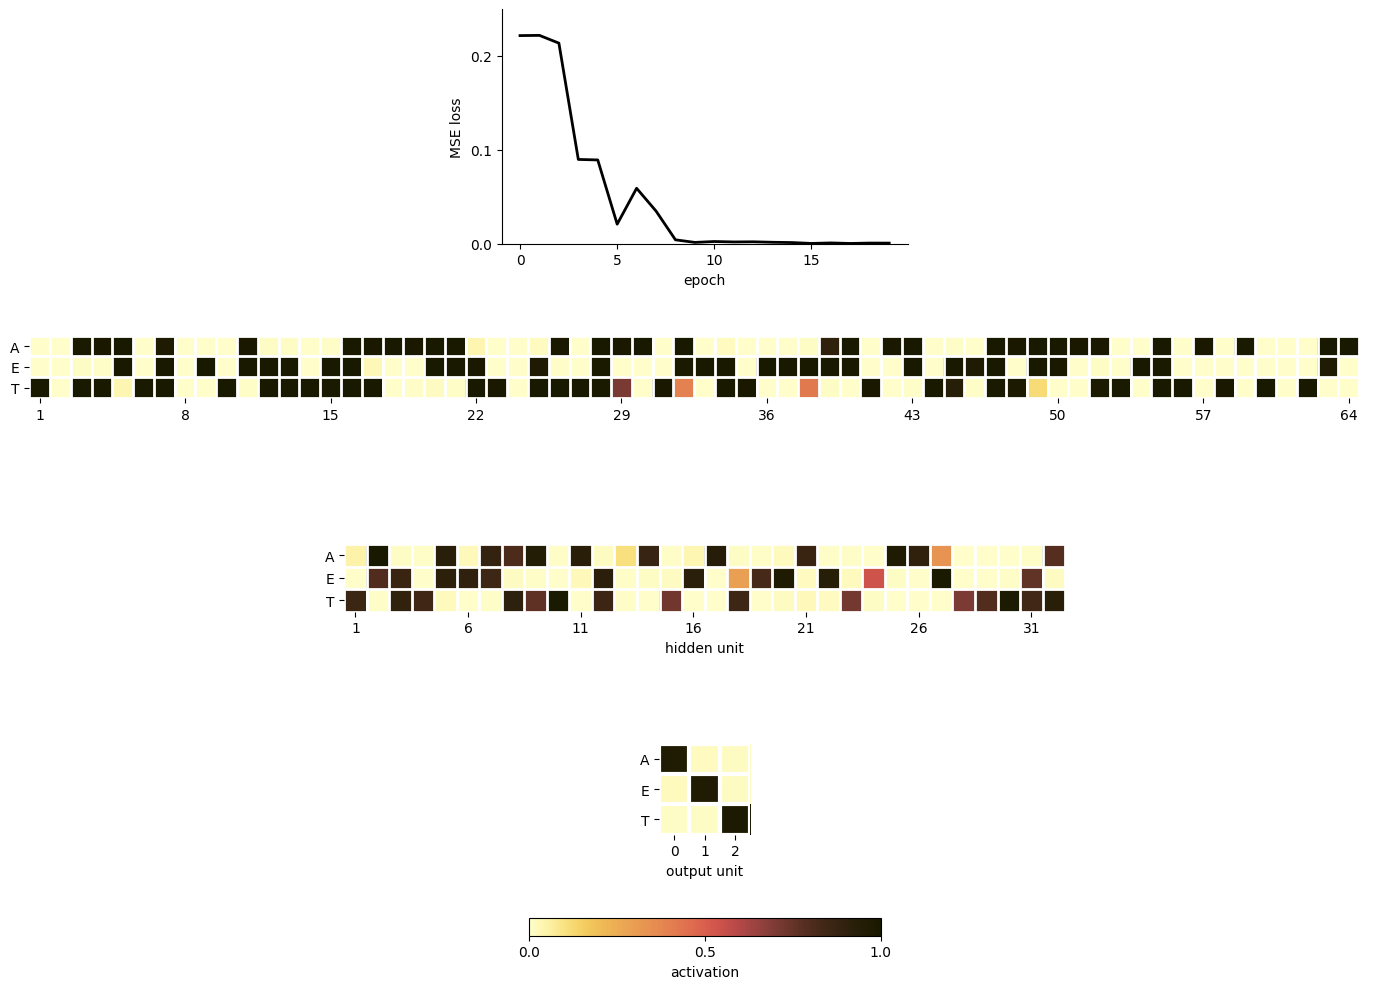

In [14]:
# plot

from matplotlib.gridspec import GridSpec


plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (14,10)


fig = plt.figure()

gs = GridSpec(5, 9, figure=fig,height_ratios = [1, .75, 0.75, .75,0.1])
ax1 = fig.add_subplot(gs[0, 3:6])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2, 2:7])
ax4 = fig.add_subplot(gs[3, 4:5])
ax5 = fig.add_subplot(gs[4,:])

ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('epoch')
ax1.set_ylim((0,0.25))
ax1.set_yticks((0,0.1,0.2))
ax1.set_xticks((0,5,10,15,20))

ax1.set_ylabel('MSE loss')
ax1.plot(np.arange(num_epo_),loss_hist2.detach().cpu(),color='k',linewidth=2)

ax2.imshow(H21[idx].detach().cpu().numpy(),cmap=cm.lajolla_r,interpolation='nearest',aspect=1)
ax2.set_xticks(np.arange(0,64,7))
ax2.set_xticklabels(np.arange(1,65,7))
ax2.set_yticks(np.arange(3))
ax2.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax2.set_xticks(np.arange(-0.5, 65, 1), minor=True)
ax2.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax2.tick_params(which='minor', bottom=False, left=False)


ax2.set_yticklabels(['A', 'E','T'])
ax2.spines[:].set_visible(False)

ax3.imshow(H22[idx].detach().cpu().numpy(),cmap=cm.lajolla_r,interpolation='nearest', aspect=1)
ax3.set_xticks(np.arange(0,32,5))
ax3.set_xticklabels(np.arange(1,32,5))

ax3.set_yticks(np.arange(3))
ax3.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax3.set_xticks(np.arange(-0.5, 32, 1), minor=True)
ax3.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax3.tick_params(which='minor', bottom=False, left=False)

ax3.spines[:].set_visible(False)

ax3.set_yticks(np.arange(3))
ax3.set_yticklabels(['A', 'E','T'])
ax3.set_xlabel('hidden unit')

im4 = ax4.imshow(O2[idx].detach().cpu().numpy(),cm.lajolla_r,interpolation='nearest',aspect=1 )
ax4.set_xticks(np.arange(0,3,1))
ax4.set_xticklabels(np.arange(3))

ax4.set_yticks(np.arange(3))
ax4.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax4.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax4.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax4.tick_params(which='minor', bottom=False, left=False)

ax4.spines[:].set_visible(False)

ax4.set_yticks(np.arange(3))
ax4.set_yticklabels(['A', 'E','T'])
ax4.set_xlabel('output unit')
ax4.set_xlim([-0.5, 2.5])
ax5.axis('off')
im4.set_clim(0,1)
cb = fig.colorbar(im4,ax=ax5,orientation='horizontal',fraction=.75)
cb.set_label('activation')
cb.set_ticks((0,0.5,1))

fig.tight_layout()
plt.show()

fig.savefig('/content/drive/MyDrive/nn_loss_activation.svg')
fig.savefig('/content/drive/MyDrive/nn_loss_activation.png')

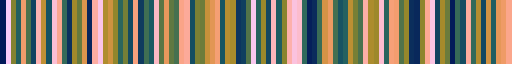

In [15]:
cm.batlowS

In [16]:
# colormap for line plots
lpcm = cm.batlowS.colors[[0,4,5],:]

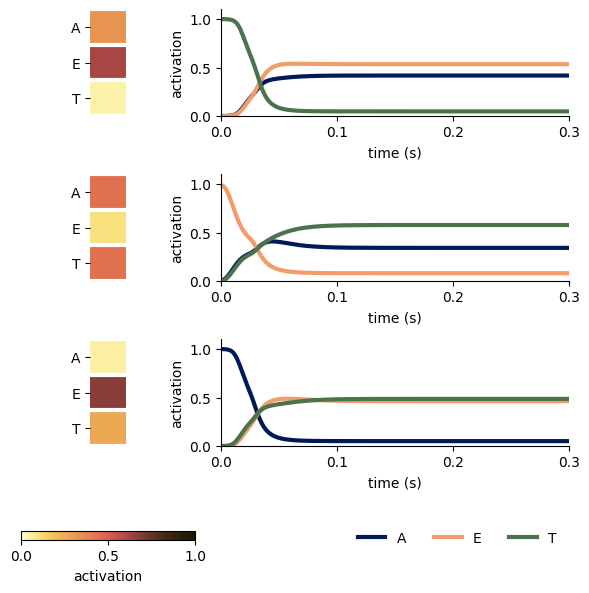

In [17]:
# show how it fails when presented with two stimuli

tau_h = 0.01
tau_R = 0.1
S = 1
c = 0

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [np.pi/2+2*np.pi/100 * 10,np.pi/2]

alpha_params = [afreq,aamp,aph]

idx = np.array((0,5,10))#,-1))
inp_combi = list(combinations(idx,2))           # possible combinations

timevec = np.linspace(0,1,1000)

plt.rcParams["figure.figsize"] = (6,6)

fig,axs = plt.subplots(4,2,height_ratios = [1, 1, 1,.5],width_ratios=[0.5, 1])

label = ['A','E','T']
for i,comp_inp in enumerate(inp_combi):
  inpt = x_train[comp_inp[0]] + x_train[comp_inp[1]]

  _,_,_,Ocmb = model2.forw_conv(inpt)

  # imshow
  imfig = axs[i,0].imshow(Ocmb.reshape(-1,1).detach().cpu().numpy(),cm.lajolla_r,interpolation='nearest',aspect=1 )
  imfig.set_clim(0,1)
  axs[i,0].set_yticks(np.arange(0,3,1))
  axs[i,0].set_yticklabels(label)

  axs[i,0].set_xticks(())

  axs[i,0].spines[:].set_visible(False)

  axs[i,0].set_yticks(np.arange(3))

  axs[i,0].set_yticklabels(['A', 'E','T'])

  axs[i,0].set_yticks(np.arange(-0.5, 3, 1), minor=True)
  axs[i,0].grid(which="minor", color="w", linestyle='-', linewidth=3)
  axs[i,0].tick_params(which='minor', bottom=False, left=False)


  # time course
  Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

  l = [None]*3
  for io,o in enumerate(Ot):
    l[io], = axs[i,1].plot(timevec,o[t+1:],linewidth=3,color=lpcm[io],label=label[io])
  axs[i,1].set_ylim((0,1))
  axs[i,1].set_xlim((0,0.3))
  axs[i,1].set_xticks(np.arange(0,0.31,0.1))

  axs[i,1].spines[['top','right']].set_visible(False)
  axs[i,1].set_ylabel('activation')
  axs[i,1].set_ylim(0,1.1)
  axs[i,1].set_xlabel('time (s)')

axs[3,0].axis('off')
axs[3,1].axis('off')
axs[3,1].legend(l,label,loc="lower right",ncol = 3,frameon=False)
cb = fig.colorbar(imfig,ax=axs[3,0],orientation='horizontal',fraction=.5)
cb.set_label('activation')
cb.set_ticks((0,0.5,1))

fig.tight_layout()

fig.savefig('/content/drive/MyDrive/bottleneck_problem.svg')
fig.savefig('/content/drive/MyDrive/bottleneck_problem.png')


# Explore dynamics single neuron

## Dynamics single unit

In [18]:
cmz = cm.lajolla_r.colors[0:-1:37]
cmz

[array([1.      , 0.997796, 0.794247]),
 array([0.959559, 0.82053 , 0.402205]),
 array([0.917784, 0.62983 , 0.324746]),
 array([0.881681, 0.458116, 0.311798]),
 array([0.738987, 0.296143, 0.28537 ]),
 array([0.446327, 0.217923, 0.185715]),
 array([0.221979, 0.142548, 0.070615])]

In [19]:
# to define a common c for all inputs, we need the maximum Z over all inputs

# get all Z's for all inputs
Zall = model2.forw_conv(x_train)[0]

# find maximum
maxZ = torch.max(Zall[:])

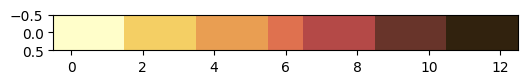

In [20]:
# get colormap
Z = torch.max(Zall[:]).detach().numpy()

cmz = cm.lajolla_r.colors[0:len(cm.lajolla_r.colors):38]

import matplotlib
cmz_map = matplotlib.colors.ListedColormap(cmz)

# colorbar plot

imfig = plt.imshow(np.array([np.arange(0.5,Z,0.5)]), cmap=cmz_map)


In [22]:
lplot_c = cm.glasgowS.colors[3:6]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-b2e0b1a1fa79>:6: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-_slope*(z+_bias)))


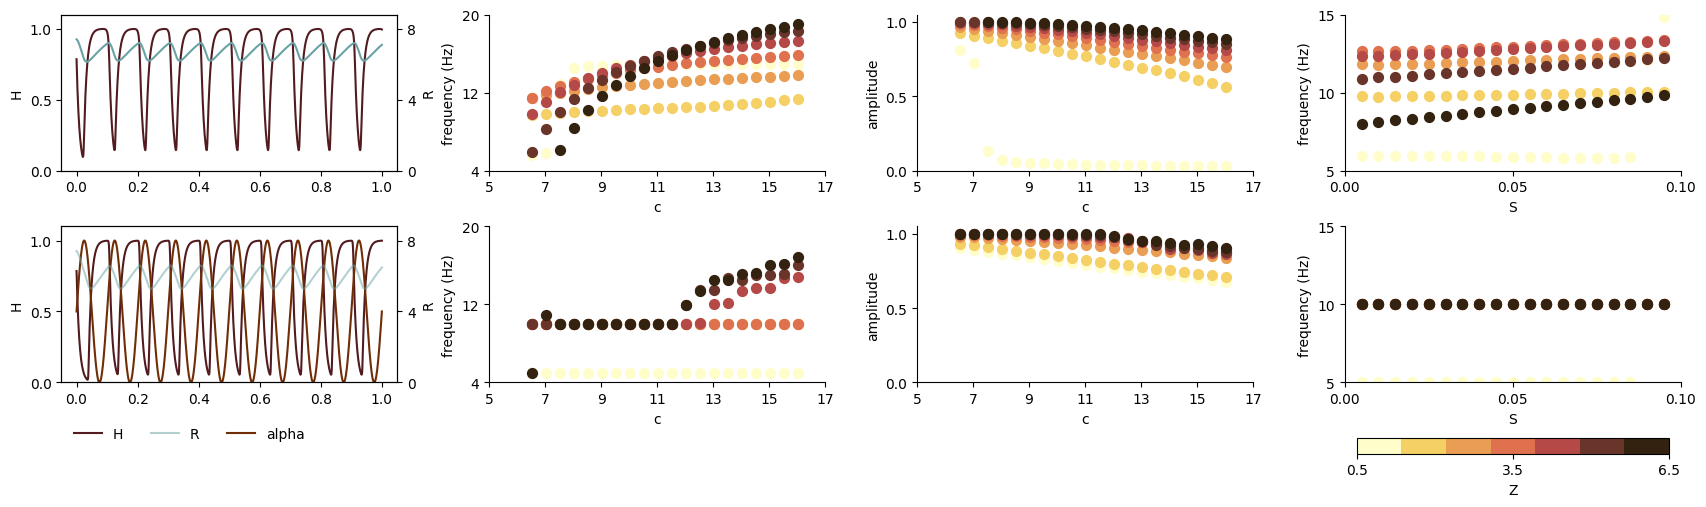

In [23]:
# to define a common c for all inputs, we need the maximum Z over all inputs

# get all Z's for all inputs
Zall = model2.forw_conv(x_train)[0]

# find maximum
Z = torch.max(Zall[:]).detach().numpy()

tau_h = 0.01
tau_R = 0.1
a = 2
S = 0.1
# fix c
c = 1.3*Z

params = [tau_h,tau_R,c,S]


# time
timevec = np.linspace(0,1,1000)

# alpha parameters

alpha_params = [10,0,0]

sig_param = [2,-2.5]

Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)


plt.rcParams["figure.figsize"] = (17,5)

fig, axs = plt.subplots(3,4,width_ratios=[1,1,1,1],height_ratios=[1,1,0.1])


# H & R ~ time

axs[0,0].plot(timevec,Ht[t_start+1:],color=lplot_c[-1])
axs[0,0].set_ylim((0,1.1))
axs[0,0].set_yticks((0,0.5,1))
axs[0,0].set_ylabel('H')

ax2 = axs[0,0].twinx()
ax2.plot(timevec,Rt[t_start+1:],color=lplot_c[1])
ax2.set_ylim((0,8.8))
ax2.set_yticks((0,4,8))
ax2.set_ylabel('R')
ax2.set_xlabel('time (s)')


# # H~R

# axs[0,1].plot(Rt[200:],Ht[200:],color='k')
# axs[0,1].set_xlim((4,8))
# axs[0,1].set_xticks((4,6,8))
# axs[0,1].set_ylim((0,1.1))
# axs[0,1].set_yticks((0,0.5,1))
# axs[0,1].set_ylabel('H')
# axs[0,1].set_xlabel('R')
# axs[0,1].spines[['top','right']].set_visible(False)


# Repeat for alpha
alpha_params = [10,0.5,0]

Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

# H & R ~ time

l[0], = axs[1,0].plot(timevec,Ht[t_start+1:],color=lplot_c[-1])
axs[1,0].set_ylim((0,1.1))
axs[1,0].set_yticks((0,0.5,1))
axs[1,0].set_ylabel('H')
l[2], = axs[1,0].plot(timevec,0.5*np.sin(2*np.pi*10*timevec)+0.5,color=lplot_c[0])

ax2 = axs[1,0].twinx()
l[1], = ax2.plot(timevec,Rt[t_start+1:],color=lplot_c[1],alpha=0.5)
ax2.set_ylim((0,8.8))
ax2.set_yticks((0,4,8))
ax2.set_ylabel('R')
ax2.set_xlabel('time (s)')



# # H~R

# axs[1,1].plot(Rt[200:],Ht[200:],color='k')
# axs[1,1].set_xlim((4,8))
# axs[1,1].set_xticks((4,6,8))
# axs[1,1].set_ylim((0,1.1))
# axs[1,1].set_yticks((0,0.5,1))
# axs[1,1].set_ylabel('H')
# axs[1,1].set_xlabel('R')
# axs[1,1].spines[['top','right']].set_visible(False)



# explore frequency for different Z's

alpha_params = [10,0,0]

# frequency as a function of C for different inputs Z

Z_vec = np.arange(0.5,Z,1)
c_vec = np.arange(Z,2.5*Z,.5)
S_vec = np.arange(0.005,0.1,0.005)
## FREQUENCY
for i,c in enumerate(c_vec):

  for iz,Z in enumerate(Z_vec):
    params = [tau_h,tau_R,c,S]
    Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

    peaks,_=scipy.signal.find_peaks(Ht)

    freq = np.mean(1/(np.diff(peaks[2:])/1000))
    pow = np.mean(Ht[peaks[2:]])

    axs[0,1].scatter(c,freq,color=cmz[iz],s=50)
    axs[0,2].scatter(c,pow,color=cmz[iz],s=50)

axs[0,1].set_ylim((4,20))
axs[0,1].set_ylabel('frequency (Hz)')
axs[0,1].set_xlabel('c')
axs[0,1].set_xlim((5,17))
axs[0,1].set_xticks(np.arange(5,18,2))
axs[0,1].set_yticks((4,12,20))
axs[0,1].spines[['top','right']].set_visible(False)

axs[0,2].set_ylim((0,1.05))
axs[0,2].set_ylabel('amplitude')
axs[0,2].set_xlabel('c')
axs[0,2].set_xlim((5,17))
axs[0,2].set_xticks(np.arange(5,18,2))
axs[0,2].set_yticks((0,0.5,1))
axs[0,2].spines[['top','right']].set_visible(False)

c = 1.3*Z_vec[-1]

for i,S in enumerate(S_vec):
  for iz,Z in enumerate(Z_vec):
    params = [tau_h,tau_R,c,S]
    Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

    peaks,_=scipy.signal.find_peaks(Ht)

    freq = np.mean(1/(np.diff(peaks[2:])/1000))
    pow = np.mean(Ht[peaks[2:]])

    axs[0,3].scatter(S,freq,color=cmz[iz],s=50)


# with alpha

alpha_params = [10,0.5,0]

S = 0.05

## FREQUENCY
for i,c in enumerate(c_vec):

  for iz,Z in enumerate(Z_vec):
    params = [tau_h,tau_R,c,S]
    Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

    peaks,_ =scipy.signal.find_peaks(Ht)

    freq = np.mean(1/(np.diff(peaks[2:])/1000))
    pow = np.mean(Ht[peaks[2:]])

    axs[1,1].scatter(c,freq,color=cmz[iz],s=50)
    axs[1,2].scatter(c,pow,color=cmz[iz],s=50)

axs[1,1].set_ylim((4,20))
axs[1,1].set_ylabel('frequency (Hz)')
axs[1,1].set_xlabel('c')
axs[1,1].set_xlim((5,17))
axs[1,1].set_xticks(np.arange(5,18,2))
axs[1,1].set_yticks((4,12,20))
axs[1,1].spines[['top','right']].set_visible(False)


axs[1,2].set_ylim((0,1.05))
axs[1,2].set_ylabel('amplitude')
axs[1,2].set_xlabel('c')
axs[1,2].set_xlim((5,17))
axs[1,2].set_xticks(np.arange(5,18,2))
axs[1,2].set_yticks((0,0.5,1))
axs[1,2].spines[['top','right']].set_visible(False)


c = 1.3*Z_vec[-1]

for i,S in enumerate(S_vec):
  for iz,Z in enumerate(Z_vec):
    params = [tau_h,tau_R,c,S]
    Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

    peaks,_=scipy.signal.find_peaks(Ht)

    freq = np.mean(1/(np.diff(peaks[2:])/1000))
    pow = np.mean(Ht[peaks[2:]])

    axs[1,3].scatter(S,freq,color=cmz[iz],s=50)


axs[1,3].set_ylim((5,15))
axs[1,3].set_ylabel('frequency (Hz)')
axs[1,3].set_xlabel('S')
axs[1,3].set_xlim((0,0.1))
axs[1,3].set_xticks(np.arange(0,0.11,0.05))
axs[1,3].set_yticks((5,10,15))
axs[1,3].spines[['top','right']].set_visible(False)

axs[0,3].set_ylim((5,15))
axs[0,3].set_ylabel('frequency (Hz)')
axs[0,3].set_xlabel('S')
axs[0,3].set_xlim((0,0.1))
axs[0,3].set_xticks(np.arange(0,0.11,0.05))
axs[0,3].set_yticks((5,10,15))
axs[0,3].spines[['top','right']].set_visible(False)

axs[2,0].axis('off')
axs[2,0].legend(l,['H','R','alpha'],loc="lower left",ncol = 3,frameon=False)

axs[2,1].axis('off')
axs[2,2].axis('off')
axs[2,3].axis('off')

cb = fig.colorbar(imfig,ax=axs[2,3],orientation='horizontal',fraction=1)
cb.set_label('Z')
cb.set_ticks((0.5,3.5,Z))

fig.tight_layout(pad = 0.5)

fig.savefig('/content/drive/MyDrive/explore_dynamics_one_node.svg')
fig.savefig('/content/drive/MyDrive/explore_dynamics_one_node.png')



In [81]:
## Find fixed point numerically

from scipy.optimize import fsolve

def func(x,Z):

  return (Z/(1.3*Z-1))+(0.05/(1.3*Z-1))*(np.log(1/x-1)/2-2.5)-x

Hstar = fsolve(func,0.3,6.5)

Hstar

Rstar = 1.3*6.5 * Hstar

In [95]:
Hstar[0], Rstar

(0.8443631426345954, array([7.13486856]))

## Explore dynamics with one input

start dynamics at fixed points

$R = \frac{c}{c-1}Z$ and
$H = \frac{Z}{c-1}$

In [25]:
# to define a common c for all inputs, we need the maximum Z over all inputs

# get all Z's for all inputs
Zall = model2.forw_conv(x_train)[0]

# find maximum
maxZ = torch.max(Zall[:])



## Dynamics NN

In [26]:
# get all activations for plots

Z21,H1,H2,O = model2.forw_conv(x_train[0])
Z22 = model2.fc1(H1)
H1 = H1.detach().cpu().numpy()
H2 = H2.detach().cpu().numpy()
O = O.detach().cpu().numpy()


In [126]:
# Dynamics one input

tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.3*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [2*np.pi/100 * 20,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

In [127]:
# alpha parameters
afreq = [10,10]
aamp = [0.5,.5]
aph = [2*np.pi/100 * 20,2*np.pi/100 * 10]#[np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1ta,Z2ta,H1ta,R1ta, H2ta, R2ta, Ota = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

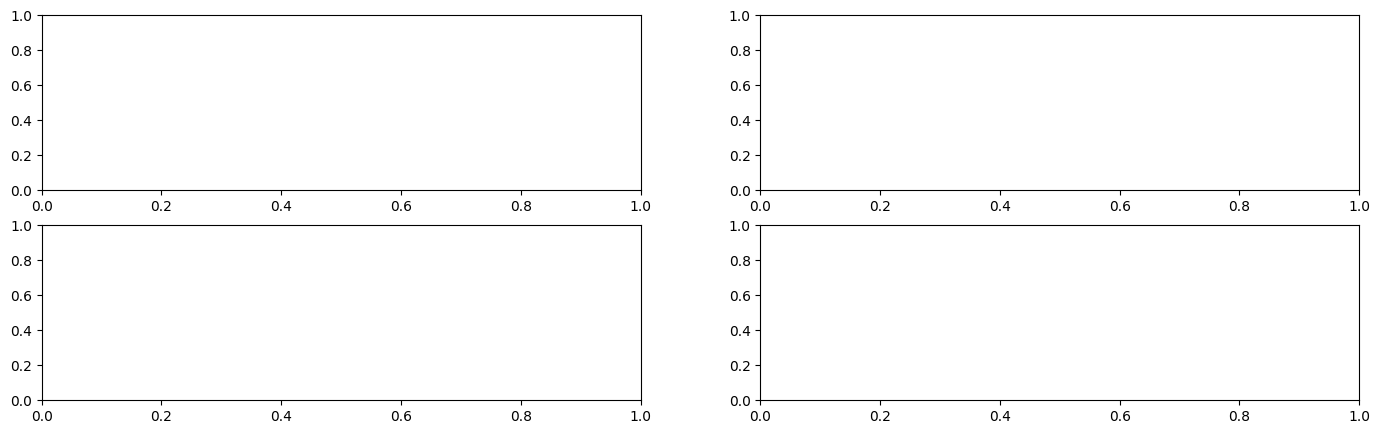

In [29]:
# smaller colormap

# cmz_small = cmz[0:10:2]
# cmz_small
# cmz_small_map = matplotlib.colors.ListedColormap(cmz_small)


# imfig = plt.imshow(np.array([[0.5,6.5]]), cmap=cmz_small_map)

fig, ax = plt.subplots(2,2)


In [141]:


Hstar = fsolve(func,0.001,args=(torch.max(Z_round).detach().numpy(),c.detach().numpy(),S))[0]

c*Hstar

tensor(7.5337, grad_fn=<MulBackward0>)

In [155]:
Z_idx

array([1., 4., 5., 6., 7.], dtype=float32)

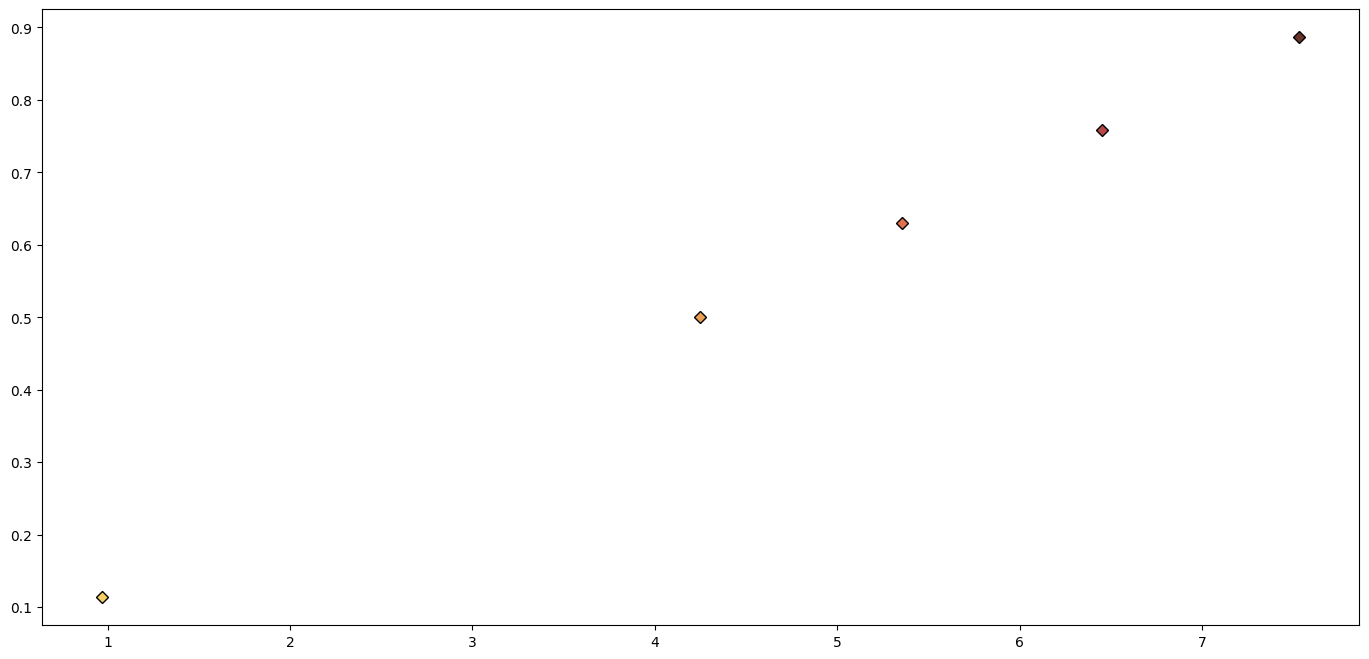

In [157]:
## only active nodes
Z = Z21.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

for i,z in enumerate(Z_idx[1]):
  # fixed point
  Hstar = fsolve(func,0.001,args=(Z_round_sort[z],c.detach().numpy(),S))[0]
  Rstar = c.detach().numpy()*Hstar

  plt.plot(Rstar,Hstar,'D',color = cmz[i+1],mec='k')

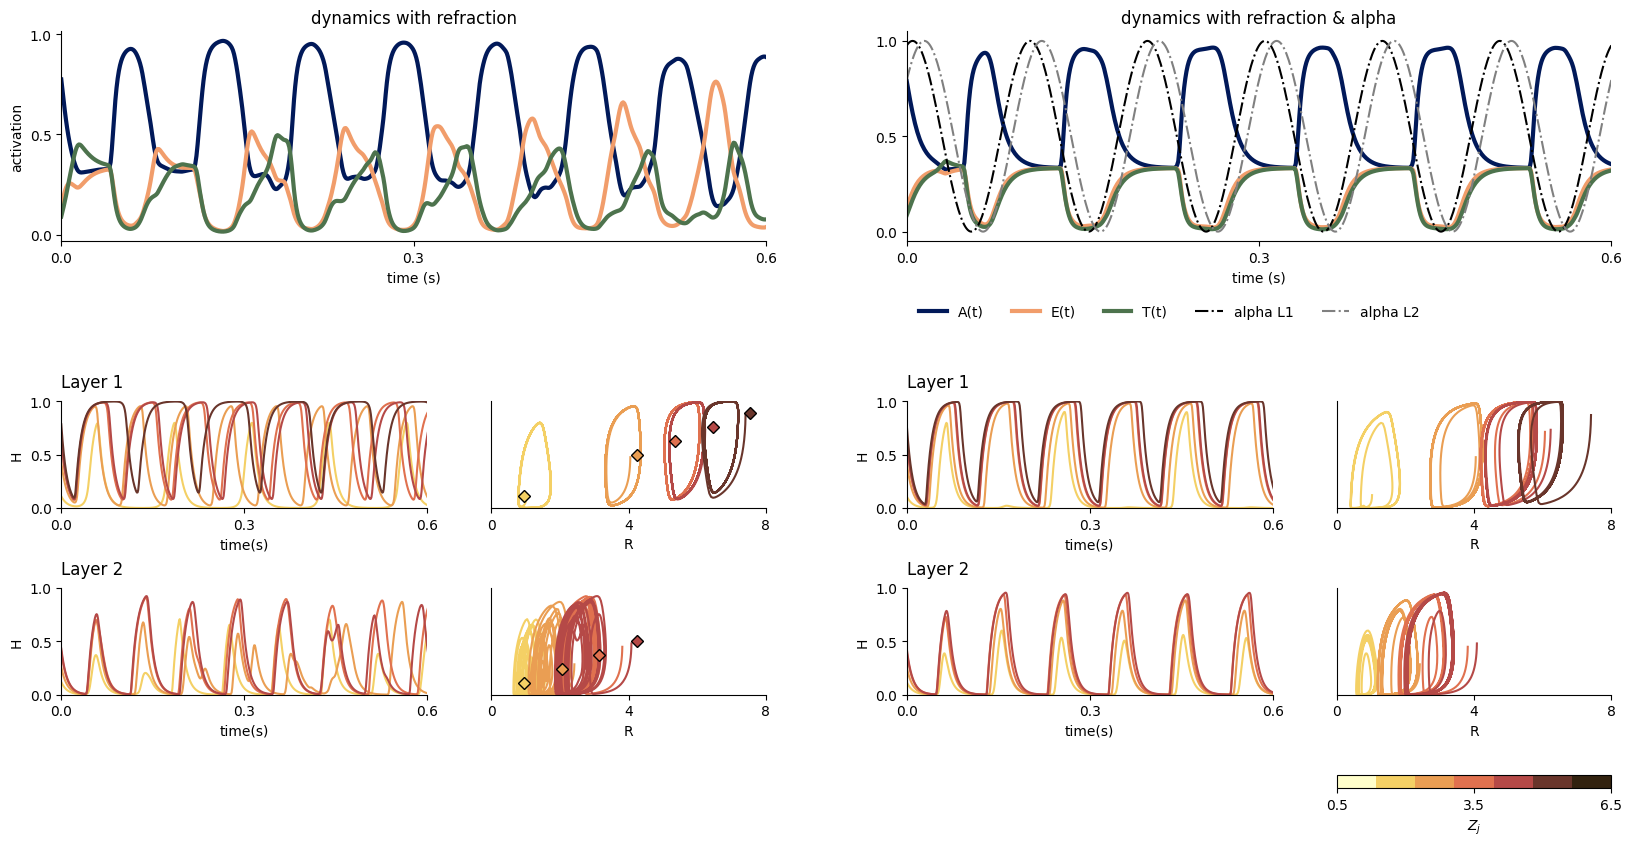

In [158]:
## Output


plt.rcParams["figure.figsize"] = (17,8)


fig = plt.figure(figsize=(20,10))


gs0 = fig.add_gridspec(2,1,height_ratios = [0.75, 1])
gs1 = gs0[0].subgridspec(2, 2,height_ratios=[1,0.3])
gs2 = gs0[1].subgridspec(3, 2,hspace=1,height_ratios=[1,1,0.25])
gs200 = gs2[0,0].subgridspec(1,2,width_ratios=[1,0.75])
gs210 = gs2[1,0].subgridspec(1,2,width_ratios=[1,0.75])
gs201 = gs2[0,1].subgridspec(1,2,width_ratios=[1,0.75])
gs211 = gs2[1,1].subgridspec(1,2,width_ratios=[1,0.75])
gscb = gs2[2,1].subgridspec(1,2,width_ratios=[1,0.75])

#fig, ax = plt.subplots(2,2,height_ratios=[1,0.25])
ax[0,0] = fig.add_subplot(gs1[0,0])
[ax[0,0].plot(timevec,ot[1:],color=lpcm[i],linewidth=3) for i,ot in enumerate(Ot)];
ax[0,0].spines[['right', 'top']].set_visible(False)
ax[0,0].set_xticks((0,0.3,0.6))
ax[0,0].set_yticks((0,0.5,1))
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel(('activation'))
ax[0,0].set_xlim((0,0.6))
ax[0,0].set_title('dynamics with refraction')

ax[1,0] = fig.add_subplot(gs1[1,1])
ax[1,0].axis('off')


ax[0,1]  = fig.add_subplot(gs1[0,1])
l = [None] * 5
for i,ot in enumerate(Ota):
  l[i], = ax[0,1].plot(timevec,ot[1:],color=lpcm[i],linewidth=3)

l[3], = ax[0,1].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.',linewidth=1.5)
l[4], = ax[0,1].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1],color = np.array((0.5, 0.5, 0.5)),linestyle='-.',linewidth=1.5)

ax[0,1].spines[['right', 'top']].set_visible(False)
ax[0,1].set_xticks((0,0.3,0.6))
ax[0,1].set_yticks((0,0.5,1))
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_xlim((0,0.6))
ax[0,1].set_title('dynamics with refraction & alpha')


ax[1,1] = fig.add_subplot(gs1[1,1])
ax[1,1].axis('off')
ax[1,1].legend(l,['A(t)','E(t)','T(t)','alpha L1', 'alpha L2'],loc='lower left',frameon=False,ncol=5)






## Layer 1

## plot activations in nodes
subax10 = fig.add_subplot(gs200[0])
subax11 = fig.add_subplot(gs200[1])

## only active nodes
Z = Z21.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

for i,z in enumerate(Z_idx[1]):
  subax10.plot(timevec[t:],H1t[Z_round_idx[z],t+1:],color = cmz[i+1])

  subax11.plot(R1t[Z_round_idx[z],:],H1t[Z_round_idx[z],:],color = cmz[i+1])

for i,z in enumerate(Z_idx[1]):

  # fixed point
  Hstar = fsolve(func,0.001,args=(Z_round_sort[z],c.detach().numpy(),S))[0]
  Rstar = c.detach().numpy()*Hstar

  plt.plot(Rstar,Hstar,'D',color = cmz[i+1],mec='k')


subax10.spines[['top','right']].set_visible(False)
subax11.spines[['top','right']].set_visible(False)



## plot activations in nodes
subax12 = fig.add_subplot(gs201[0])
subax13 = fig.add_subplot(gs201[1])

## only active nodes
Z = Z21.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

for i,z in enumerate(Z_idx[1]):
  subax12.plot(timevec[t:],H1ta[Z_round_idx[z],t+1:],color = cmz[i+1])

  subax13.plot(R1ta[Z_round_idx[z],:],H1ta[Z_round_idx[z],:],color = cmz[i+1])


subax12.spines[['top','right']].set_visible(False)
subax13.spines[['top','right']].set_visible(False)

subax13.set_xlim((0,7))
subax13.set_xticks(np.arange(0,9,4))
subax11.set_xlim((0,7))
subax11.set_xticks(np.arange(0,9,4))



## Layer 2

## plot activations in nodes
subax20 = fig.add_subplot(gs210[0])
subax21 = fig.add_subplot(gs210[1])

## only active nodes
Z = Z22.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

for i,z in enumerate(Z_idx[1]):
  subax20.plot(timevec[t:],H2t[Z_round_idx[z],t+1:],color = cmz[i+1])

  subax21.plot(R2t[Z_round_idx[z],:],H2t[Z_round_idx[z],:],color = cmz[i+1])


for i,z in enumerate(Z_idx[1]):

  # fixed point
  Hstar = fsolve(func,0.001,args=(Z_round_sort[z],c.detach().numpy(),S))[0]
  Rstar = c.detach().numpy()*Hstar

  plt.plot(Rstar,Hstar,'D',color = cmz[i+1],mec='k')


subax20.spines[['top','right']].set_visible(False)
subax21.spines[['top','right']].set_visible(False)
subax20.set_xlim((0,0.6))
subax20.set_xticks(np.arange(0,0.7,0.3))

## plot activations in nodes
subax22 = fig.add_subplot(gs211[0])
subax23 = fig.add_subplot(gs211[1])

## only active nodes
Z = Z22.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

for i,z in enumerate(Z_idx[1]):
  subax22.plot(timevec[t:],H2ta[Z_round_idx[z],t+1:],color = cmz[i+1])

  subax23.plot(R2ta[Z_round_idx[z],:],H2ta[Z_round_idx[z],:],color = cmz[i+1])

subax23.set_xlim((0,7))
subax23.set_xticks(np.arange(0,9,4))
subax21.set_xlim((0,7))
subax21.set_xticks(np.arange(0,9,4))




subax22.spines[['top','right']].set_visible(False)

subax23.spines[['top','right']].set_visible(False)




subax10.set_xlim((0,0.6))
subax10.set_xticks(np.arange(0,0.7,0.3))

subax12.set_xlim((0,0.6))
subax12.set_xticks(np.arange(0,0.7,0.3))

subax20.set_xlim((0,0.6))
subax20.set_xticks(np.arange(0,0.7,0.3))

subax22.set_xlim((0,0.6))
subax22.set_xticks(np.arange(0,0.7,0.3))



subax10.set_ylim((0,1))
subax20.set_ylim((0,1))
subax11.set_ylim((0,1))
subax21.set_ylim((0,1))
subax12.set_ylim((0,1))
subax22.set_ylim((0,1))

subax13.set_ylim((0,1))
subax23.set_ylim((0,1))

subax10.set_yticks((0,0.5,1))
subax20.set_yticks((0,0.5,1))
subax11.set_yticks(())
subax21.set_yticks(())
subax12.set_yticks((0,0.5,1))
subax22.set_yticks((0,0.5,1))

subax13.set_yticks(())
subax23.set_yticks(())

subax11.set_yticklabels(())
subax21.set_yticklabels(())

subax13.set_yticklabels(())
subax23.set_yticklabels(())

subax10.set_ylabel('H')
subax20.set_ylabel('H')
subax10.set_xlabel('time(s)')
subax20.set_xlabel('time(s)')

subax12.set_ylabel('H')
subax22.set_ylabel('H')
subax12.set_xlabel('time(s)')
subax22.set_xlabel('time(s)')

subax11.set_xlabel('R')
subax21.set_xlabel('R')

subax13.set_xlabel('R')
subax23.set_xlabel('R')


# titles
subax20.set_title('Layer 2',loc='left',pad=10)
subax22.set_title('Layer 2',loc='left',pad=10)
subax10.set_title('Layer 1',loc='left',pad=10)
subax12.set_title('Layer 1',loc='left',pad=10)



subcb = fig.add_subplot(gscb[1])
subcb.axis('off')
cb = fig.colorbar(imfig,ax=subcb,orientation='horizontal',fraction=1)
cb.set_label('$Z_j$')
cb.set_ticks((0.5,3.5,6.5))


fig.savefig('/content/drive/MyDrive/dynamics_NN_one_input.svg')
fig.savefig('/content/drive/MyDrive/dynamics_NN_one_input.png')

### Dynamics with alpha

Entrainment!

### Two inputs

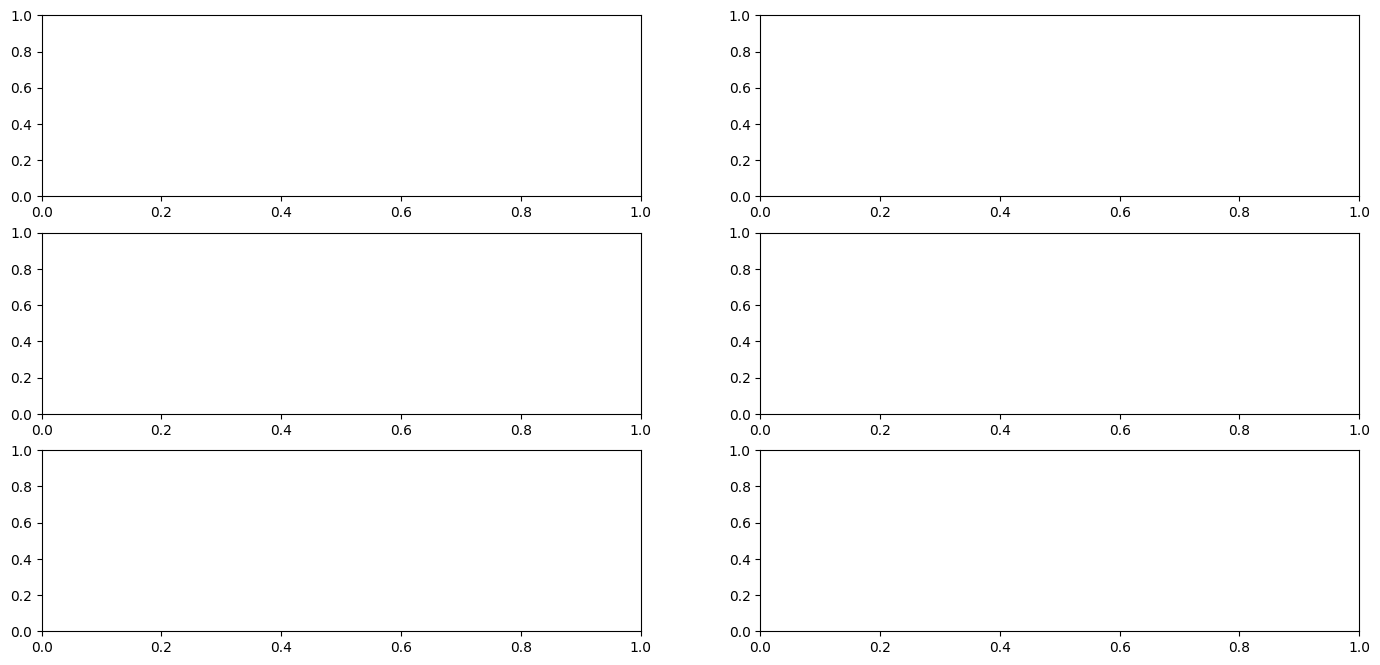

In [31]:
fig,ax = plt.subplots(3,2)

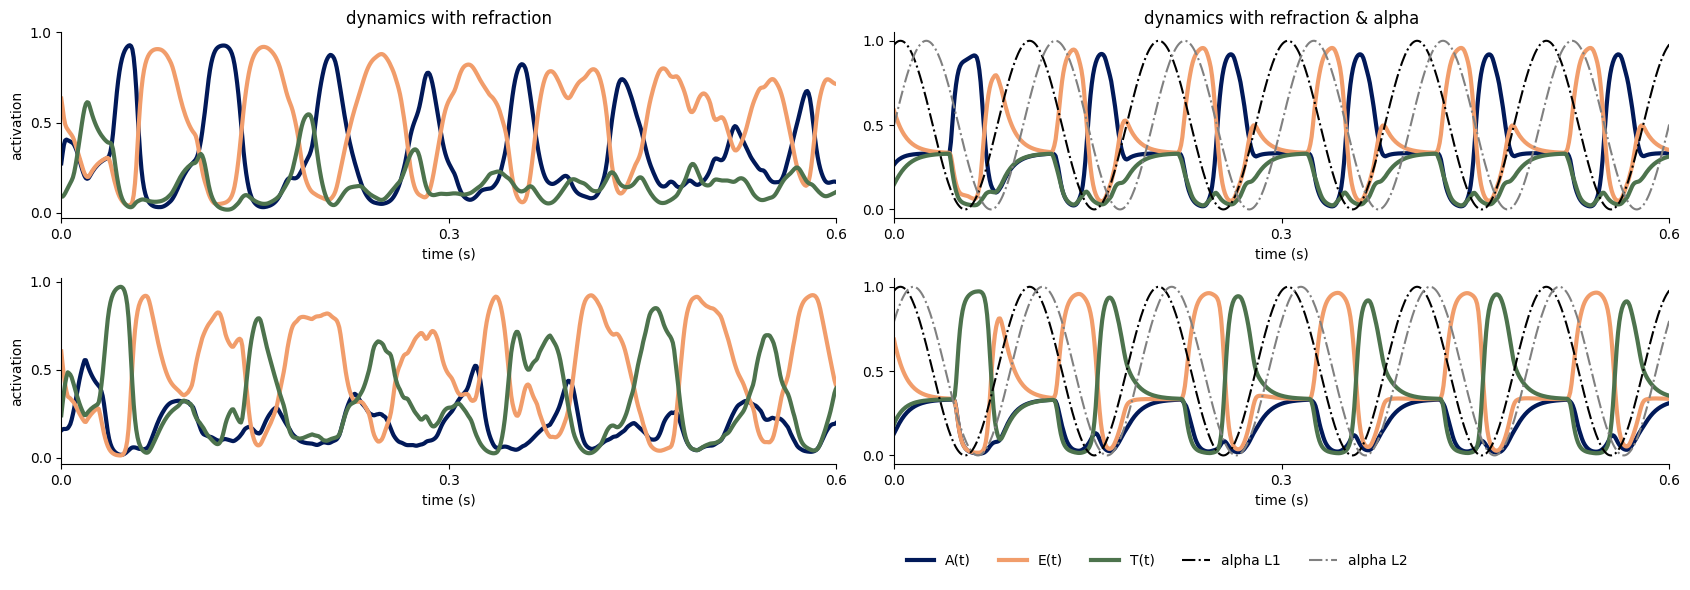

In [32]:

fig = plt.figure(figsize=(17,6))


gs0 = fig.add_gridspec(3,2,height_ratios = [1,1,0.3])


# E & A

# without alpha

# Dynamics one input

tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.3*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [2*np.pi/100 * 20,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


inpt = x_train[5]*1.2 + x_train[0]*.8


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)



# with alpha
tau_h = 0.01
tau_R = 0.1
S = .05
c = 1.4*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]
aph = [2*np.pi/100 * 20,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1ta,Z2ta,H1ta,R1ta, H2ta, R2ta, Ota = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)


#fig, ax = plt.subplots(2,2,height_ratios=[1,0.25])
ax[0,0] = fig.add_subplot(gs0[0,0])
[ax[0,0].plot(timevec,ot[1:],color=lpcm[i],linewidth=3) for i,ot in enumerate(Ot)];
ax[0,0].spines[['right', 'top']].set_visible(False)
ax[0,0].set_xticks((0,0.3,0.6))
ax[0,0].set_yticks((0,0.5,1))
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel(('activation'))
ax[0,0].set_xlim((0,0.6))
ax[0,0].set_title('dynamics with refraction')


ax[0,1]  = fig.add_subplot(gs0[0,1])
l = [None] * 5
for i,ot in enumerate(Ota):
  l[i], = ax[0,1].plot(timevec,ot[1:],color=lpcm[i],linewidth=3)

l[3], = ax[0,1].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.',linewidth=1.5)
l[4], = ax[0,1].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1],color = np.array((0.5, 0.5, 0.5)),linestyle='-.',linewidth=1.5)

ax[0,1].spines[['right', 'top']].set_visible(False)
ax[0,1].set_xticks((0,0.3,0.6))
ax[0,1].set_yticks((0,0.5,1))
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_xlim((0,0.6))
ax[0,1].set_title('dynamics with refraction & alpha')


## E and T

inpt = x_train[6]*1.2 + x_train[-1]*.8


# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [2*np.pi/100 * 20,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)




Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)



# with alpha
tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.2*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]
aph = [2*np.pi/100 * 20,2*np.pi/100 * 10]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1ta,Z2ta,H1ta,R1ta, H2ta, R2ta, Ota = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)




#fig, ax = plt.subplots(2,2,height_ratios=[1,0.25])
ax[1,0] = fig.add_subplot(gs0[1,0])
[ax[1,0].plot(timevec,ot[1:],color=lpcm[i],linewidth=3) for i,ot in enumerate(Ot)];
ax[1,0].spines[['right', 'top']].set_visible(False)
ax[1,0].set_xticks((0,0.3,0.6))
ax[1,0].set_yticks((0,0.5,1))
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel(('activation'))
ax[1,0].set_xlim((0,0.6))




ax[1,1]  = fig.add_subplot(gs0[1,1])
l = [None] * 5
for i,ot in enumerate(Ota):
  l[i], = ax[1,1].plot(timevec,ot[1:],color=lpcm[i],linewidth=3)

l[3], = ax[1,1].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.',linewidth=1.5)
l[4], = ax[1,1].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1],color = np.array((0.5, 0.5, 0.5)),linestyle='-.',linewidth=1.5)

ax[1,1].spines[['right', 'top']].set_visible(False)
ax[1,1].set_xticks((0,0.3,0.6))
ax[1,1].set_yticks((0,0.5,1))
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_xlim((0,0.6))



ax[2,0] = fig.add_subplot(gs0[2,0])
ax[2,0].axis('off')
ax[2,1] = fig.add_subplot(gs0[2,1])
ax[2,1].axis('off')
ax[2,1].legend(l,['A(t)','E(t)','T(t)','alpha L1', 'alpha L2'],loc='lower left',frameon=False,ncol=5)


fig.tight_layout()

fig.savefig('/content/drive/MyDrive/dynamics_NN_two_inputs_example.svg')
fig.savefig('/content/drive/MyDrive/dynamics_NN_two_inputs_example.png')

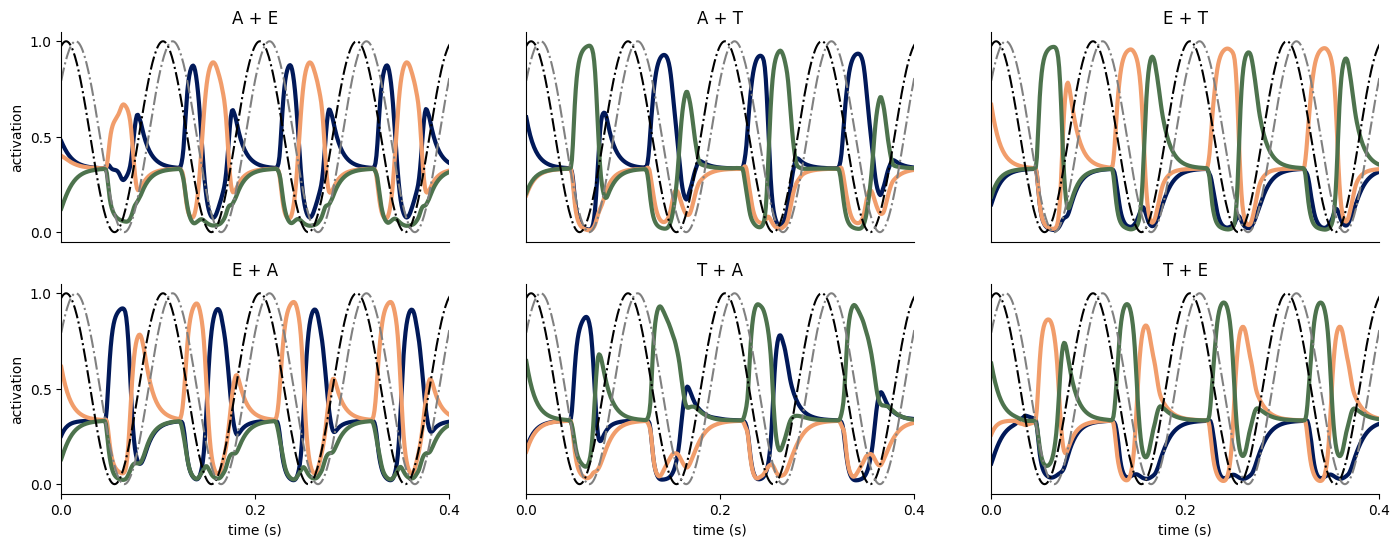

In [33]:
# try other combinations of inputs



# Dynamics two inputs

tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.3*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]
aph = [2*np.pi/100 * 20,2*np.pi/100 * 10]#[np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)

inpt = x_train[0]*1.2 + x_train[5]*0.8



idx = np.array((0,5,10))#,-1))
inp_combi = list(combinations(idx,2))           # possible combinations


labels = ['A', 'E', 'T']
label_comb = list(combinations(labels,2))
label_comb

plt.rcParams["figure.figsize"] = (17,6)


fig,axs = plt.subplots(2,3)

for i,comp_inp in enumerate(inp_combi):

  inpt = x_train[comp_inp[0]]*1.2 + x_train[comp_inp[1]]*.8

  Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

  [axs[0,i].plot(timevec,ot[1:],linewidth=3,color=lpcm[iot]) for iot,ot in enumerate(Ot)];

  if alpha_params[1][0]:
    axs[0,i].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

  if alpha_params[1][1]:
    axs[0,i].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


  axs[0,i].set_title(label_comb[i][0] + ' + ' + label_comb[i][1])


  axs[0,i].set_xlim((0,0.4))
  axs[0,i].set_xticks(())
  axs[0,i].spines[['top','right']].set_visible(False)


# clean up axes
axs[0,0].set_ylabel('activation')
axs[0,0].set_yticks((0,0.5,1))



for i,comp_inp in enumerate(inp_combi):

  inpt = x_train[comp_inp[1]]*1.2 + x_train[comp_inp[0]]*.8

  Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

  [axs[1,i].plot(timevec,ot[1:],linewidth=3,color=lpcm[iot]) for iot,ot in enumerate(Ot)];

  if alpha_params[1][0]:
    axs[1,i].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

  if alpha_params[1][1]:
    axs[1,i].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


  axs[1,i].set_title(label_comb[i][1] + ' + ' + label_comb[i][0])


  axs[1,i].set_xlim((0,0.4))
  axs[1,i].set_xticks((0,0.2,0.4))
  axs[1,i].set_xlabel('time (s)')
  axs[1,i].spines[['top','right']].set_visible(False)


# clean up axes
axs[1,0].set_ylabel('activation')
axs[1,0].set_yticks((0,0.5,1))


axs[1,1].set_yticks(())
axs[1,2].set_yticks(())

axs[0,1].set_yticks(())
axs[0,2].set_yticks(())

fig.savefig('/content/drive/MyDrive/dynamics_NN_two_inputs_allcomb.svg')
fig.savefig('/content/drive/MyDrive/dynamics_NN_two_inputs_allcomb.png')


### Check pipeline

In [34]:
_,H1,H2,O = model2.forw_conv(x_train)

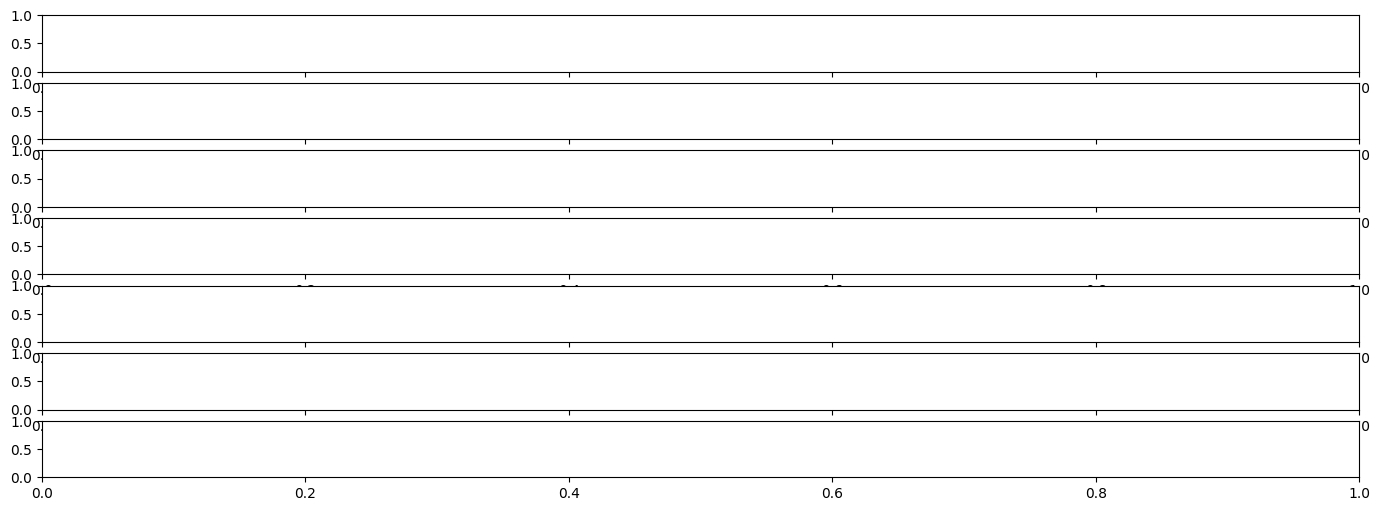

In [35]:
fig,axs = plt.subplots(7,1) # empty


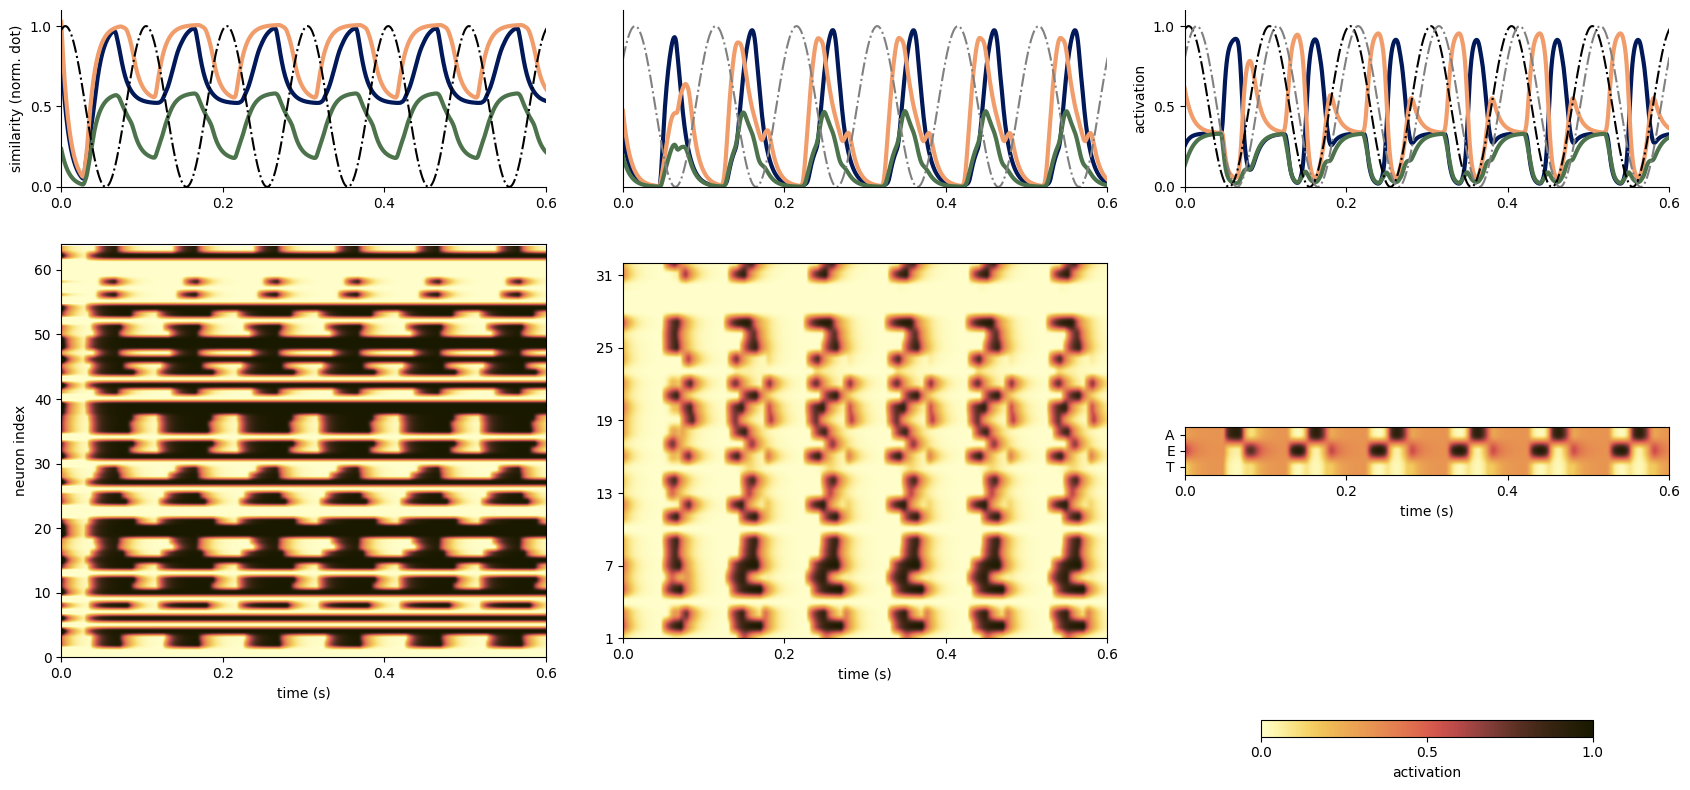

In [36]:
## Activation change over time for E & A combination

idx_stim = [6,0]

tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.3*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [.5,.5]
aph = [2*np.pi/100 * 20,2*np.pi/100 * 10]#[np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq,aamp,aph]


inpt = x_train[idx_stim[0]]*1.2 + x_train[idx_stim[1]]*.8

Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

plt.rcParams["figure.figsize"] = (17,6)

# plots
# 1 temporal code
# 2 similarity H1 to activation each stimulus alone
# 3 TFR style activation H1 over time

fig = plt.figure(figsize=(17,8))

gs = GridSpec(1, 3, figure=fig)

gs01 = gs[0].subgridspec(3, 1, height_ratios = [.4, 1,0.05])
gs02 = gs[1].subgridspec(3, 1, height_ratios = [.4, 1,0.05])
gs03 = gs[2].subgridspec(3, 1, height_ratios = [.4, 1,0.05])

axs[0] = fig.add_subplot(gs01[0])
axs[1] = fig.add_subplot(gs01[1])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
axs[2] = fig.add_subplot(gs02[0])
axs[3]= fig.add_subplot(gs02[1])
axs[4] = fig.add_subplot(gs03[0])
axs[5]= fig.add_subplot(gs03[1])
axs[6]= fig.add_subplot(gs03[2])
# similarity single input activation in H

# correlation coefficienct does weird things - do a normalized dot product

H1corrA = np.array([(torch.dot(H1t[:,t],H1[0])/torch.dot(H1[0],H1[0])).detach().numpy() for t in range(H1t.shape[1])])
H1corrE = np.array([(torch.dot(H1t[:,t],H1[5])/torch.dot(H1[5],H1[5])).detach().numpy() for t in range(H1t.shape[1])])
H1corrT = np.array([(torch.dot(H1t[:,t],H1[-1])/torch.dot(H1[-1],H1[-1])).detach().numpy() for t in range(H1t.shape[1])])

axs[0].plot(timevec,H1corrA[t+1:],color=lpcm[0],linewidth=3)
axs[0].plot(timevec,H1corrE[t+1:],color=lpcm[1],linewidth=3)
axs[0].plot(timevec,H1corrT[t+1:],color=lpcm[2],linewidth=3)

axs[0].set_ylim([0,1.1])
axs[0].set_yticks(np.arange(0,1.1,0.5))
axs[0].set_xlim([0,1])
axs[0].spines[['top','right']].set_visible(False)
axs[0].set_ylabel('similarity (norm. dot)')


if alpha_params[1][0]:
  axs[0].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')


iml1=axs[1].imshow(H1t,aspect=8,cmap=cm.lajolla_r)
iml1.set_clim(0,1)
axs[1].set_xticks(np.arange(0,1200,200))
axs[1].set_xticklabels(np.round(np.arange(0,1.2,0.2),decimals=1))
axs[1].set_xlabel('time (s)')
ax2.set_xticks(np.arange(0,64,7))
ax2.set_xticklabels(np.arange(1,65,7))
axs[1].set_ylim([0,64])
axs[1].set_ylabel('neuron index')


# Layer 2

# similarity single input activation in H

H2corrA = np.array([(torch.dot(H2t[:,t],H2[0])/torch.dot(H2[0],H2[0])).detach().numpy() for t in range(H2t.shape[1])])
H2corrE = np.array([(torch.dot(H2t[:,t],H2[5])/torch.dot(H2[5],H2[5])).detach().numpy() for t in range(H2t.shape[1])])
H2corrT = np.array([(torch.dot(H2t[:,t],H2[-1])/torch.dot(H2[-1],H2[-1])).detach().numpy() for t in range(H2t.shape[1])])

axs[2].plot(timevec,H2corrA[t+1:],color=lpcm[0],linewidth=3)
axs[2].plot(timevec,H2corrE[t+1:],color=lpcm[1],linewidth=3)
axs[2].plot(timevec,H2corrT[t+1:],color=lpcm[2],linewidth=3)

axs[2].set_ylim([0,1.1])
axs[2].set_yticks(())
axs[2].set_xlim([0,1])
axs[2].spines[['top','right']].set_visible(False)
#axs[3].set_ylabel('similarity (normalized dot)')

if alpha_params[1][1]:
  axs[2].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


iml2 = axs[3].imshow(H2t,aspect=15,cmap=cm.lajolla_r)
iml2.set_clim(0,1)
axs[3].set_xticks(np.arange(0,1200,200))
axs[3].set_xticklabels(np.round(np.arange(0,1.2,0.2),decimals=1))
axs[3].set_xlabel('time (s)')
axs[3].set_yticks(np.arange(0,33,6))
axs[3].set_yticklabels(np.arange(1,32,6))
axs[3].set_ylim([0,31])
#axs[4].set_ylabel('neuron index')

# axs[2].set_yticks(np.arange(-0.5, 65, 1), minor=True)
# axs[2].grid(which="minor", color="w", linestyle='-', linewidth=2)
# axs[2].tick_params(which='minor', bottom=False, left=False)



[axs[4].plot(timevec,ot[1:],linewidth=3,color=lpcm[iot]) for iot,ot in enumerate(Ot)];

if alpha_params[1][0]:
  axs[4].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

if alpha_params[1][1]:
  axs[4].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


axs[4].set_ylim([0,1.1])
axs[4].set_yticks((0,0.5,1))
axs[4].set_ylabel('activation')

axs[4].spines[['top','right']].set_visible(False)

imout = axs[5].imshow(Ot,aspect=20,cmap=cm.lajolla_r)
axs[5].set_xticks(np.arange(0,1200,200))
axs[5].set_xticklabels(np.round(np.arange(0,1.2,0.2),decimals=1))
axs[5].set_xlabel('time (s)')
axs[5].set_yticks(np.arange(0,3,1))
axs[5].set_yticklabels(['A','E','T'])



# clean up axes
axs[0].set_xlim((0,0.6))
axs[1].set_xlim((0,600))
axs[2].set_xlim((0,0.6))
axs[3].set_xlim((0,600))
axs[4].set_xlim((0,0.6))
axs[5].set_xlim((0,600))


axs[0].set_xticks(np.arange(0,0.8,0.2))
axs[2].set_xticks(np.arange(0,0.8,0.2))
axs[4].set_xticks(np.arange(0,0.8,0.2))

# axs[5]
# axs[5].set_ylim([-0.5,2.5])
imout.set_clim((0,1))

axs[6].axis('off')
cb = fig.colorbar(imout,ax=axs[6],orientation='horizontal',fraction=0.75)
cb.set_label('activation')
cb.set_ticks((0,0.5,1))

fig.tight_layout()


fig.savefig('/content/drive/MyDrive/dynamics_NN_separation.svg')
fig.savefig('/content/drive/MyDrive/dynamics_NN_separation.png')
